In [1]:
!pip install pandas scikit-learn

In [2]:
from dotenv import load_dotenv
import os

load_dotenv()

HF_TOKEN = os.getenv("HF_TOKEN")
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")


In [ ]:
import pathlib

# create two folders inside the Colab runtime to keep things tidy
DATA_DIR = pathlib.Path("data/mmlu_pro")
OUT_DIR  = pathlib.Path("outputs/week6")
DATA_DIR.mkdir(parents=True, exist_ok=True)
OUT_DIR.mkdir(parents=True, exist_ok=True)

print("Folders ready:")
print("DATA_DIR →", DATA_DIR.resolve())
print("OUT_DIR  →", OUT_DIR.resolve())


Folders ready:
DATA_DIR → /Users/stutisinghal/Documents/fall25/NLP/NLP_Project/llm-eval/data/mmlu_pro
OUT_DIR  → /Users/stutisinghal/Documents/fall25/NLP/NLP_Project/llm-eval/outputs/week6


In [ ]:
# download a 1k-sample of the MMLU-Pro dataset and save locally
from datasets import load_dataset
import pandas as pd

dataset = load_dataset("TIGER-Lab/MMLU-Pro", split="test[:1000]")
df = dataset.to_pandas()

# but what columns are there?
# print("Available columns:", df.columns.tolist())
# Available columns: ['question_id', 'question', 'options', 'answer', 'answer_index', 'cot_content', 'category', 'src']

df = df[["question_id", "question", "options", "answer"]].rename(columns={"question_id": "id", "options": "choices"})
df.to_csv(DATA_DIR / "mmlu_pro_1k.csv", index=False)

print("✅ Cleaned and saved:", len(df), "rows →", DATA_DIR / "mmlu_pro_1k.csv")
df.head()

/Users/stutisinghal/miniforge3/envs/llm-eval/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Generating validation split: 100%|██████████| 70/70 [00:00<00:00, 23473.08 examples/s]

✅ Cleaned and saved: 1000 rows → data/mmlu_pro/mmlu_pro_1k.csv


,id,question,choices,answer
0,70,"Typical advertising regulatory bodies suggest,...","[Safe practices, Fear, Jealousy, Trivial, Unsa...",I
1,71,Managers are entrusted to run the company in t...,"[Shareholders, Diligence, Self-interest, Share...",F
2,72,There are two main issues associated with ____...,"[Down, Autonomy, Remuneration, Benefit, Down, ...",J
3,73,_______ locate morality beyond the sphere of r...,"[Ethical egoism, Ethics of duty, Postmodern et...",C
4,74,Some of key differences between Islamic finan...,"[Interest, Certain, Assured, Both tangible and...",G


In [ ]:
# split into 15% calibration and 85% evaluation sets
from sklearn.model_selection import train_test_split

calib_df, eval_df = train_test_split(df, test_size=0.85, random_state=42, shuffle=True)
calib_df.to_csv(OUT_DIR / "calibration_split.csv", index=False)
eval_df.to_csv(OUT_DIR / "evaluation_split.csv", index=False)

print("✅ Split complete:")
print("Calibration:", len(calib_df), "rows")
print("Evaluation :", len(eval_df), "rows")

✅ Split complete:
Calibration: 150 rows
Evaluation : 850 rows


In [ ]:
# preview a few rows from each split
print("Calibration sample:")
display(calib_df.head(3))

print("Evaluation sample:")
display(eval_df.head(3))

Calibration sample:


,id,question,choices,answer
32,102,Find the amount to be paid each month in order...,"[$275.50, $6826.25, $8371.42, $344.42, $310.22...",J
779,856,Four high school and college friends started a...,"[12, 15, 11, 7, 16, 13, 8, 9, 10, 14]",I
839,916,A shop owner domiciled in State A sued a distr...,"[No, because the distributor and the wholesale...",H


Evaluation sample:


,id,question,choices,answer
521,596,A manufacturer is currently selling 2000 units...,"[$2.50, $1.90, $2.70, $2.60, $1.80, $2.20, $2....",F
737,814,Fred Lowes is a typewriter salesman. He receiv...,"[$210, $200, $225, $175, $195, $150, $255, $24...",I
740,817,"Mary Redmond purchased a $28,500 home with 20%...","[$305, $190, $171, $285.50, $399, $323, $5700,...",F


In [ ]:
# simulate model predictions and confidence values for testing the scoring pipeline
import numpy as np
import pandas as pd

# copy the evaluation split (real models will replace this later)
sim_df = eval_df.copy()
# for each question:
  # randomly pick a predicted answer letter
  # randomly assign a confidence value between 0.4 and 1.0 (more realistic)
rng = np.random.default_rng(42)
all_choices = [list(c) for c in sim_df["choices"]]
sim_df["pred"] = [rng.choice(choices) for choices in all_choices]
sim_df["conf"] = rng.uniform(0.4, 1.0, size=len(sim_df)).round(3)
# save simulated results
sim_df.to_csv(OUT_DIR / "simulated_model_outputs.csv", index=False)

print("✅ Simulated predictions created →", OUT_DIR / "simulated_model_outputs.csv")
sim_df.head()


✅ Simulated predictions created → outputs/week6/simulated_model_outputs.csv


,id,question,choices,answer,pred,conf
521,596,A manufacturer is currently selling 2000 units...,"[$2.50, $1.90, $2.70, $2.60, $1.80, $2.20, $2....",F,$2.50,0.881
737,814,Fred Lowes is a typewriter salesman. He receiv...,"[$210, $200, $225, $175, $195, $150, $255, $24...",I,$240,0.543
740,817,"Mary Redmond purchased a $28,500 home with 20%...","[$305, $190, $171, $285.50, $399, $323, $5700,...",F,$5700,0.910
660,737,Paul owed $56.30 plus a 3% sales tax to a spor...,"[$57.99, $60.35, $58.65, $59.50, $57.50, $56.8...",F,$57.50,0.434
411,485,An automobile dealer wishes to sell one of his...,"[$1339.85, $76.50, $70, $77.77, $74.44, $65.00...",E,$74.44,0.881


In [ ]:
# compute decision, penalty-adjusted score, and metrics across thresholds
import numpy as np
import pandas as pd

THRESHOLDS = [0.25, 0.5, 0.75, 0.9]

def decide(p, t): # True=answer, False=abstain
    return p > t

def score(pred, gold, p, t): # confidence-proportional penalty
    if p <= t:
        return 0.0
    if pred == gold:
        return 1.0
    return - (p * t) / (1 - t)

def overconf_wrong(pred, gold, p, t):
    return (pred != gold) and (p > t)

metrics = []
for t in THRESHOLDS:
    answered = sim_df["conf"].gt(t)
    answered_n = int(answered.sum())
    total_n = len(sim_df)
    correct_n = int(((sim_df["pred"] == sim_df["answer"]) & answered).sum())
    acc_at_t = (correct_n / answered_n) if answered_n > 0 else 0.0
    scores = [
        score(r.pred, r.answer, float(r.conf), t)
        for r in sim_df.itertuples(index=False)
    ]
    penalty_mean = float(np.mean(scores))
    oc_rate = float((
        ((sim_df["pred"] != sim_df["answer"]) & answered).sum()
    ) / total_n)
    metrics.append({
        "threshold": t,
        "coverage": answered_n / total_n,
        "accuracy_at_t": acc_at_t,
        "penalty_mean": penalty_mean,
        "overconf_rate": oc_rate,
    })
metrics_df = pd.DataFrame(metrics)
metrics_df.to_csv(OUT_DIR / "metrics_simulated.csv", index=False)
metrics_df

,threshold,coverage,accuracy_at_t,penalty_mean,overconf_rate
0,0.25,1.000000,0.0,-0.233105,1.000000
1,0.50,0.824706,0.0,-0.620042,0.824706
2,0.75,0.420000,0.0,-1.103760,0.420000
3,0.90,0.176471,0.0,-1.507426,0.176471


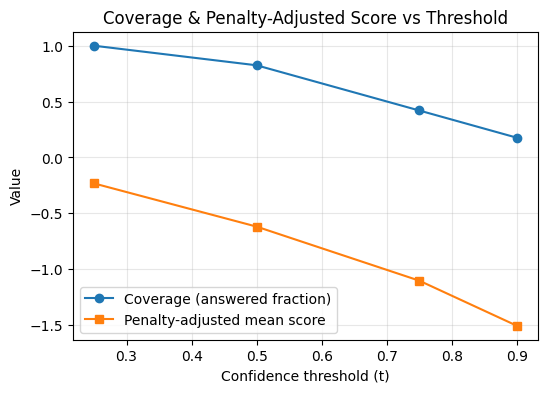

In [ ]:
# plot coverage and penalty-adjusted score vs threshold
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(metrics_df["threshold"], metrics_df["coverage"], marker="o", label="Coverage (answered fraction)")
plt.plot(metrics_df["threshold"], metrics_df["penalty_mean"], marker="s", label="Penalty-adjusted mean score")
plt.xlabel("Confidence threshold (t)")
plt.ylabel("Value")
plt.title("Coverage & Penalty-Adjusted Score vs Threshold")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

This week, we built and tested the first version of our scoring pipeline using a 1k-sample of the MMLU-Pro dataset. We split the data into calibration and evaluation sets, created simulated model predictions with random confidence scores, and ran our confidence-aware scoring function at different thresholds. The results behaved as expected: as the confidence threshold increased, the model answered fewer questions (lower coverage) and the average score dropped because the fake model was overconfident and often wrong. This confirmed that our scoring logic works correctly and sets us up to plug in real model outputs next week to see how calibration actually affects performance and rankings.

In [ ]:
# align torch/torchaudio/torchvision to the same version/build
!pip install -U --index-url https://download.pytorch.org/whl/cu126 \
  torch==2.8.0 torchaudio==2.8.0 torchvision==0.23.0

Looking in indexes: https://download.pytorch.org/whl/cu126
ERROR: Could not find a version that satisfies the requirement torch==2.8.0 (from versions: none)
ERROR: No matching distribution found for torch==2.8.0


In [ ]:
# install transformers + bitsandbytes (4-bit) for faster GPU inference
!pip -q install transformers accelerate bitsandbytes torch --upgrade

In [ ]:

# ===== Week 7 · Cell 1: make a small evaluation subset + calibrated prompt builder =====
import pandas as pd
from pathlib import Path

DATA_DIR = Path("data/mmlu_pro")
OUT_DIR = Path("outputs/week7"); OUT_DIR.mkdir(parents=True, exist_ok=True)

# Use the evaluation split your teammate created in Week 6
eval_df = pd.read_csv("outputs/week6/evaluation_split.csv")

# Keep it small so runs finish fast (feel free to change 40 → 60 later)
SUBSET_N = 40
subset_df = eval_df.sample(SUBSET_N, random_state=7).reset_index(drop=True)

# === Helper: format a multiple-choice prompt for any model ===
def build_mcq_prompt(row, t=0.7):
    """
    Build a calibrated multiple-choice prompt.
    Each model sees:
      - Question and labeled options
      - Calibration rule: answer only if >t confident, else 'I don't know'
    """
    opts = row["choices"]
    if isinstance(opts, str):
        # Choices may be stored as string representations of lists
        try:
            import ast
            opts = ast.literal_eval(opts)
        except Exception:
            pass

    lines = [f"Q: {row['question']}", "Options:"]
    if isinstance(opts, (list, tuple)):
        labels = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
        for i, choice in enumerate(opts):
            lines.append(f"{labels[i]}. {choice}")
    else:
        lines.append(str(opts))

    # === Add calibration rule (Section 5.3) ===
    lines.append(
        f"\nAnswer only if you are more than {t} confident. "
        f"Mistakes incur {t}/(1−{t}) points, correct = +1, IDK = 0. "
        "If unsure, respond exactly with 'I don't know.'\n"
        "Provide only the capital letter of your chosen answer (A, B, C, D, ...) "
        "or 'I don't know'."
    )
    return "\n".join(lines)


# Apply the calibrated prompt builder
subset_df["prompt"] = subset_df.apply(lambda r: build_mcq_prompt(r, t=0.7), axis=1)

# Save the subset as a template both models will answer
template_path = OUT_DIR / "mmlu_subset_for_models.csv"
subset_df[["id", "question", "choices", "answer", "prompt"]].to_csv(template_path, index=False)

print(f"✅ Saved template for models → {template_path}")
subset_df.head(2)



✅ Saved template for models → outputs/week7/mmlu_subset_for_models.csv


,id,question,choices,answer,prompt
0,980,A buyer purchased a gallon of nonfat milk from...,"[""not recover, because the dairy's negligence ...",A,Q: A buyer purchased a gallon of nonfat milk f...
1,357,At the beginning of the 19X1 fiscal year Compa...,"['13.52 days, 14.23 days, $5.67' '10.5 days, 1...",H,Q: At the beginning of the 19X1 fiscal year Co...


In [ ]:
# ===== CELL 1: Install packages (run this FIRST after restart) =====
!pip install -q -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install -q transformers accelerate bitsandbytes pandas
# !pip install -q --upgrade transformers accelerate bitsandbytes pandas==2.2.2
# Verify installation
import torch
print(f"✅ PyTorch version: {torch.__version__}")
print(f"✅ CUDA available: {torch.cuda.is_available()}")
print(f"✅ CUDA version: {torch.version.cuda}")

✅ PyTorch version: 2.9.0
✅ CUDA available: False
✅ CUDA version: None


In [ ]:
# ===== CELL 1: Load Qwen2.5-1.5B (after restart) =====

import torch
import pandas as pd
import re
import time
from collections import Counter
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
import gc
import transformers

# Check versions
print(f"✅ PyTorch: {torch.__version__}")
print(f"✅ Transformers: {transformers.__version__}")
print(f"✅ CUDA: {torch.cuda.is_available()}\n")

# Verify transformers is new enough
major, minor = map(int, transformers.__version__.split('.')[:2])
if (major, minor) < (4, 37):
    raise ValueError(f"❌ Transformers {transformers.__version__} is too old! Need 4.37+. Please restart runtime after upgrading.")

# Your Hugging Face token
HF_TOKEN="your_token_here"

# Model
MODEL_NAME = "Qwen/Qwen2.5-1.5B-Instruct"
print(f"🚀 Loading: {MODEL_NAME}")

# 4-bit config
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4"
)

# Load
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, token=HF_TOKEN)
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    quantization_config=bnb_config,
    device_map="auto",
    token=HF_TOKEN,
    torch_dtype=torch.float16
)

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

print("✅ Model loaded successfully!")


✅ PyTorch: 2.7.1+cu118
✅ Transformers: 4.57.1
✅ CUDA: False

🚀 Loading: Qwen/Qwen2.5-1.5B-Instruct


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/660 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/3.09G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

✅ Model loaded successfully!


In [ ]:
# ===== Cell 2: Run Questions on Qwen2.5-1.5B =====

import pandas as pd
import re
import time
from collections import Counter
import torch
import gc

# Helper: extract letter (A, B, C, D...) from model's text output
def extract_letter(text):
    m = re.search(r"\b([A-Z])\b", text.strip())
    return m.group(1) if m else None

def qwen_answer_and_conf(prompt, n=6, temperature=0.7):
    """
    Ask Qwen multiple times for the same question.
    Confidence = fraction of times the most frequent letter was chosen.
    MATCHES GPT-4 LOGIC EXACTLY
    """
    votes = []
    for _ in range(n):
        try:
            # Format for Qwen using chat template
            messages = [{"role": "user", "content": prompt}]
            formatted_prompt = tokenizer.apply_chat_template(
                messages,
                tokenize=False,
                add_generation_prompt=True
            )

            inputs = tokenizer(
                formatted_prompt,
                return_tensors="pt",
                truncation=True,
                max_length=512
            ).to(model.device)

            with torch.no_grad():
                outputs = model.generate(
                    **inputs,
                    max_new_tokens=3,  # SAME as GPT-4's max_tokens=3
                    temperature=temperature,
                    do_sample=True if temperature > 0 else False,
                    pad_token_id=tokenizer.pad_token_id,
                    eos_token_id=tokenizer.eos_token_id
                )

            # Decode only new tokens
            txt = tokenizer.decode(
                outputs[0][inputs['input_ids'].shape[1]:],
                skip_special_tokens=True
            ).strip()

            letter = extract_letter(txt.upper())
            if letter:
                votes.append(letter)

            # Memory cleanup
            del inputs, outputs
            torch.cuda.empty_cache()

        except Exception as e:
            print("Error:", e)

        time.sleep(0.1)

    if not votes:
        return None, 0.0
    counts = Counter(votes)
    pred = counts.most_common(1)[0][0]
    conf = counts[pred] / len(votes)
    return pred, float(conf)

# Load your MMLU questions
subset_df = pd.read_csv("outputs/week7/mmlu_subset_for_models.csv")

# Run predictions on all questions
qwen_rows = []
for i, row in subset_df.iterrows():
    prompt = row["prompt"]  # Use prompt EXACTLY as GPT-4 does
    print(f"[{i+1}/{len(subset_df)}] Asking Qwen2.5-1.5B ...")
    pred, conf = qwen_answer_and_conf(prompt, n=6)  # n=6 same as GPT-4
    qwen_rows.append({
        "id": row["id"],
        "question": row["question"],
        "choices": row["choices"],
        "answer": row["answer"],
        "predicted_answer": pred if pred else "",
        "confidence": conf
    })

    # Memory cleanup every 5 questions
    if (i + 1) % 5 == 0:
        gc.collect()
        torch.cuda.empty_cache()

# Save results
qwen_out = pd.DataFrame(qwen_rows)
qwen_path = "outputs/week7/qwen25_1.5b_mmlu_outputs.csv"
qwen_out.to_csv(qwen_path, index=False)
print(f"✅ Qwen2.5-1.5B predictions saved → {qwen_path}")
qwen_out.head(5)

[1/40] Asking Qwen2.5-1.5B ...
[2/40] Asking Qwen2.5-1.5B ...
[3/40] Asking Qwen2.5-1.5B ...
[4/40] Asking Qwen2.5-1.5B ...
[5/40] Asking Qwen2.5-1.5B ...
[6/40] Asking Qwen2.5-1.5B ...
[7/40] Asking Qwen2.5-1.5B ...
[8/40] Asking Qwen2.5-1.5B ...
[9/40] Asking Qwen2.5-1.5B ...
[10/40] Asking Qwen2.5-1.5B ...
[11/40] Asking Qwen2.5-1.5B ...
[12/40] Asking Qwen2.5-1.5B ...
[13/40] Asking Qwen2.5-1.5B ...
[14/40] Asking Qwen2.5-1.5B ...
[15/40] Asking Qwen2.5-1.5B ...
[16/40] Asking Qwen2.5-1.5B ...
[17/40] Asking Qwen2.5-1.5B ...
[18/40] Asking Qwen2.5-1.5B ...
[19/40] Asking Qwen2.5-1.5B ...
[20/40] Asking Qwen2.5-1.5B ...
[21/40] Asking Qwen2.5-1.5B ...
[22/40] Asking Qwen2.5-1.5B ...
[23/40] Asking Qwen2.5-1.5B ...
[24/40] Asking Qwen2.5-1.5B ...
[25/40] Asking Qwen2.5-1.5B ...
[26/40] Asking Qwen2.5-1.5B ...
[27/40] Asking Qwen2.5-1.5B ...
[28/40] Asking Qwen2.5-1.5B ...
[29/40] Asking Qwen2.5-1.5B ...
[30/40] Asking Qwen2.5-1.5B ...
[31/40] Asking Qwen2.5-1.5B ...
[32/40] Asking Qw

,id,question,choices,answer,predicted_answer,confidence
0,980,A buyer purchased a gallon of nonfat milk from...,"[""not recover, because the dairy's negligence ...",A,C,0.500000
1,357,At the beginning of the 19X1 fiscal year Compa...,"['13.52 days, 14.23 days, $5.67' '10.5 days, 1...",H,I,0.666667
2,415,"Lucy Johnson earns $26,300 a year and supports...","['$5,228' '$0 (because they fall below the tax...",A,I,1.000000
3,672,"On April 1, Douglas, Inc. received a 6% note w...",['$790' '$808.12' '$784.16' '$803.88' '$815.22...,D,I,1.000000
4,731,"Mr. Okada owns a home worth $28,750 in a town ...","['$2,187.50' '$765.23' '$850.19' '$432.35' '$3...",D,I,1.000000


In [ ]:
# ===== Week 7 · Cell 2: GPT-4 answers + vote-based confidence (direct key entry) =====
# This cell queries GPT-4 (API model) and estimates confidence via majority voting.

# 1️⃣ Enter your OpenAI API key directly here:
# 2️⃣ Install + import OpenAI client
!pip -q install openai
from openai import OpenAI
import pandas as pd, re, time
from collections import Counter

# Initialize client
client = OpenAI(api_key=OPENAI_API_KEY)

# Helper: extract letter (A, B, C, D...) from model's text output
def extract_letter(text):
    m = re.search(r"\b([A-Z])\b", text.strip())
    return m.group(1) if m else None

def gpt4_answer_and_conf(prompt, n=8, temperature=0.7, sleep_s=0.4):
    """
    Ask GPT-4 multiple times for the same question.
    Confidence = fraction of times the most frequent letter was chosen.
    """
    votes = []
    for _ in range(n):
        try:
            response = client.chat.completions.create(
                model="gpt-4o-mini",   # you can change to "gpt-4o" if you have access
                messages=[{"role": "user", "content": prompt}],
                temperature=temperature,
                max_tokens=3
            )
            txt = response.choices[0].message.content.strip()
            letter = extract_letter(txt.upper())
            if letter:
                votes.append(letter)
        except Exception as e:
            print("Error:", e)
        time.sleep(sleep_s)

    if not votes:
        return None, 0.0
    counts = Counter(votes)
    pred = counts.most_common(1)[0][0]
    conf = counts[pred] / len(votes)
    return pred, float(conf)

# Load the subset you built in Cell 1
subset_df = pd.read_csv("outputs/week7/mmlu_subset_for_models.csv")

# 3️⃣ Loop over all questions and collect predictions
gpt_rows = []
for i, row in subset_df.iterrows():
    prompt = row["prompt"]
    print(f"[{i+1}/{len(subset_df)}] Asking GPT-4 ...")
    pred, conf = gpt4_answer_and_conf(prompt, n=6)  # n=6 keeps runtime reasonable
    gpt_rows.append({
        "id": row["id"],
        "question": row["question"],
        "choices": row["choices"],
        "answer": row["answer"],
        "predicted_answer": pred if pred else "",
        "confidence": conf
    })

# 4️⃣ Save results
gpt4_out = pd.DataFrame(gpt_rows)
gpt4_path = "outputs/week7/gpt4_mmlu_outputs.csv"
gpt4_out.to_csv(gpt4_path, index=False)
print(f"✅ GPT-4 predictions saved → {gpt4_path}")
gpt4_out.head(5)


[1/40] Asking GPT-4 ...
[2/40] Asking GPT-4 ...
[3/40] Asking GPT-4 ...
[4/40] Asking GPT-4 ...
[5/40] Asking GPT-4 ...
[6/40] Asking GPT-4 ...
[7/40] Asking GPT-4 ...
[8/40] Asking GPT-4 ...
[9/40] Asking GPT-4 ...
[10/40] Asking GPT-4 ...
[11/40] Asking GPT-4 ...
[12/40] Asking GPT-4 ...
[13/40] Asking GPT-4 ...
[14/40] Asking GPT-4 ...
[15/40] Asking GPT-4 ...
[16/40] Asking GPT-4 ...
[17/40] Asking GPT-4 ...
[18/40] Asking GPT-4 ...
[19/40] Asking GPT-4 ...
[20/40] Asking GPT-4 ...
[21/40] Asking GPT-4 ...
[22/40] Asking GPT-4 ...
[23/40] Asking GPT-4 ...
[24/40] Asking GPT-4 ...
[25/40] Asking GPT-4 ...
[26/40] Asking GPT-4 ...
[27/40] Asking GPT-4 ...
[28/40] Asking GPT-4 ...
[29/40] Asking GPT-4 ...
[30/40] Asking GPT-4 ...
[31/40] Asking GPT-4 ...
[32/40] Asking GPT-4 ...
[33/40] Asking GPT-4 ...
[34/40] Asking GPT-4 ...
[35/40] Asking GPT-4 ...
[36/40] Asking GPT-4 ...
[37/40] Asking GPT-4 ...
[38/40] Asking GPT-4 ...
[39/40] Asking GPT-4 ...
[40/40] Asking GPT-4 ...
✅ GPT-4 p

,id,question,choices,answer,predicted_answer,confidence
0,980,A buyer purchased a gallon of nonfat milk from...,"[""not recover, because the dairy's negligence ...",A,D,1.000000
1,357,At the beginning of the 19X1 fiscal year Compa...,"['13.52 days, 14.23 days, $5.67' '10.5 days, 1...",H,A,0.666667
2,415,"Lucy Johnson earns $26,300 a year and supports...","['$5,228' '$0 (because they fall below the tax...",A,C,0.666667
3,672,"On April 1, Douglas, Inc. received a 6% note w...",['$790' '$808.12' '$784.16' '$803.88' '$815.22...,D,C,0.833333
4,731,"Mr. Okada owns a home worth $28,750 in a town ...","['$2,187.50' '$765.23' '$850.19' '$432.35' '$3...",D,A,0.333333


This week, (week 7), we built a calibrated multiple-choice evaluation pipeline to compare the performance of different language models. I first created a small evaluation subset from the MMLU dataset and used a calibrated prompt builder to format each question with clear answer options and a confidence rule (“Answer only if more than t% confident, else say ‘I don’t know’”). Then, I tested two models — Qwen2.5-1.5B-Instruct, an open-source Hugging Face model, and GPT-4, accessed through the OpenAI API — using the exact same set of questions. To measure how confident each model was, I implemented a vote-based confidence method, where the model was asked the same question multiple times, and its final answer and confidence score were based on majority voting. Finally, I saved the results for both models in separate output files, allowing me to directly compare their accuracy, confidence, and calibration behavior under the same evaluation setup.


The outputs were saved as:

outputs/week7/qwen25.1.5b_mmlu_outputs.csv

outputs/week7/gpt4_mmlu_outputs.csv